In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

let's generate a synthetic data set of measurements of some quantity that has some mean and variance, that we will want to try to determine from the data set


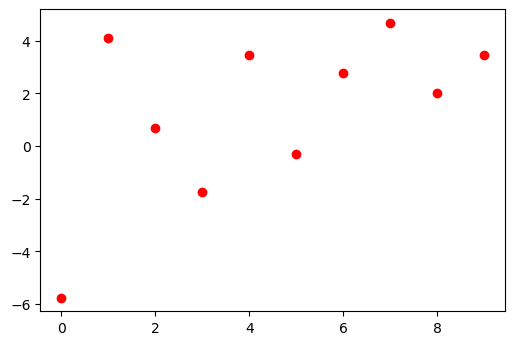

In [51]:
# create a random distribution from input parameters m0, s0
m0,s0= 0,3   # your choice of input mean and standard deviation here!
npts=10    # if we have a large number of points, we'll have to be careful about calculating
           #  total probabilities, because they will be a very small number!
y=np.random.normal(m0,s0,size=npts)

plt.figure(dpi=100)
plt.plot(y,'ro')
plt.show()


We want to determine the mean and the standard deviation of the sample.

First, let's use the standard statistical approach. Given a set of N measurements, what is the most likely value of the mean and the standard deviation? These are just the sample mean and sample standard deviation! 

Compute the values for your simulated data set:


In [52]:
# code to compute sample mean and standard deviation here
sample = y
sample_mean = sum(sample)/len(sample)
sample_std = np.sqrt(sum((sample-sample_mean)**2)/(len(sample)-1))
print('sample mean: {:8.3f}  sample standard deviation: {:8.3f}'.format(sample_mean,sample_std))

sample mean:    1.335  sample standard deviation:    3.216


What about the uncertainty on the sample mean? What is the standard result? 


In [53]:
# expression for standard error of the mean
sem=  sample_std/np.sqrt(len(sample))
print('uncertainty in mean: {:8.3f}'.format(sem))

uncertainty in mean:    1.017


OK, now let's consider the Bayesian appproach to the problem. Here we want to determine the posterior probability distribution function for the mean and standard deviation of our data set.

We will do so explicitly:
$$P(\mu,\sigma | D) = {P(D|\mu,\sigma) P(\mu,\sigma) \over P(D) }$$
We are not able to calculate $P(D)$ so we will just do the numerator, but then require that it integrates to unity so that we have a proper posteriod distribution function.

First, write the routine for the likelihood of our data set, given arbitrary $\mu$,$\sigma$. The probability of a single data point is:

$$P(x_i|\mu,\sigma) = {1\over \sigma\sqrt{2\pi}} \exp {-0.5(x_i-\mu)^2\over \sigma^2}$$

The probability of the full data set is just the product of the individual probabilities.

Write a routine to return the likelihood of the data set. You may want to use the [numpy.prod()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.prod.html) function.

However, note for large npts, the likelihood will get extremely small, and you may run into numerical underflow problems, so you may want to consider a log(likelihood) routine

In [54]:
def gauss(x,m,s) :
    """ Gaussian function"""
    return 1/np.sqrt(2*np.pi)/s * np.exp(-0.5*(x-m)**2/s**2)

def L(y,m,s):
    """ Likelihood of full data set
        y : input set of data points
        m, s : trial mean and standard deviation to use
        
        # return the expression for the likelihood of the data set, which is the
        #  product of the likelihoods of the individual data points for the input mean and standard deviation
    """
    N = len(y)
    first_term = (1/(s*np.sqrt(2*np.pi)))**N
    exp_term = np.exp( np.sum( -(y-m)**2/(2*s**2)  ))
    return first_term*exp_term   # add calculation of L here
 
# log-likelihood function for given data, mean, and standard deviation
def logL(y,m,s) :
    """return the loglikelihood of the data set"""

    N = len(y)
    first_term = (-N/2)*np.log(2*np.pi*s**2)
    exp_term = -(1/(2*s**2))*np.sum((y-m)**2)
    # logL is a sum instead of a product
    return first_term + exp_term    # add calculation of logL here

To get the posterior PDF, we need to multiply the likelihood by the prior. What is an appropriate prior $P(\mu,\sigma$?
$\mu$ is a location parameter, so a flat prior is appropriate. $\sigma$ is a scaling parameter, so a Jeffreys prior $P(\sigma) \propto {1\over \sigma}$ is appropriate

In [55]:
#routine to return prior
def prior(m,s) :
    """ return prior for input mean and standard deviation """
    return  1/s   # add calculation of prior here

Now calculate the posterior probability for a grid of mean and standard deviation

In [68]:
# make a grid of L for various mean and sigma
n=100
# set appropriate ranges for your trial mean and standard deviation and create a grid over which
#  you will compute the posterior
mgrid=np.linspace(-3,6,n)   # choose limits for grid mean
sgrid=np.linspace(0.5,7,n)  # choose limits for grid standard deviation

Ppdf=np.zeros([n,n])
log_Ppdf=np.zeros([n,n])

# fill the grid
for ix,m in enumerate(mgrid) :
    for iy,s in enumerate(sgrid) :
        Ppdf[iy,ix] =  L(y,m,s)*prior(m,s)     # product of likelihood and prior
        log_Ppdf[iy,ix] =  logL(y,m,s)+np.log(prior(m,s)) # sum of log(L) and log(prior)

#if you are using a log(Ppdf), convert back to Ppdf, but after adding a constant to avoid underflow
alt_Ppdf = np.exp(log_Ppdf - log_Ppdf.max())
        

Normalize the posterior PDF so that it sums to unity, and display it

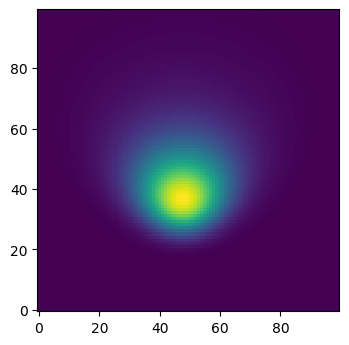

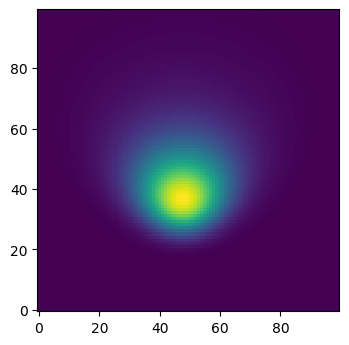

In [69]:
# normalize the likelihood to have an integral of unity
Ppdf = Ppdf/Ppdf.sum()
alt_Ppdf = alt_Ppdf/alt_Ppdf.sum()

plt.figure(dpi=100)
plt.imshow(Ppdf,origin='lowerleft')
plt.show()

plt.figure(dpi=100)
plt.imshow(alt_Ppdf,origin='lowerleft')
plt.show()

Now plot the marginal distributions for mean, and determine the "1-sigma" credible region by looking at the cumulative distribution function of the marginal distribution. You may want to use the [numpy.cumsum()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) function

credible interval:  0.27272727272727293 2.2727272727272725


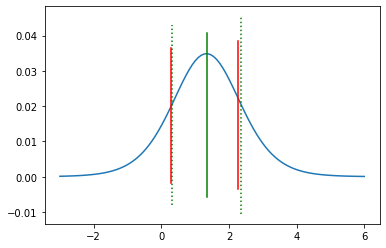

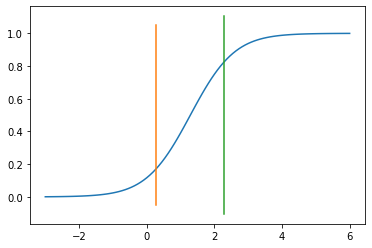

In [70]:
# get the marginal distribution function by marginalizing (summing) over the sigma axis
mdf= Ppdf.sum(axis=0)      # sum over the first axis
plt.plot(mgrid,mdf)

# get the cumulative distribution function of this to determined credible region
cdf= np.cumsum(mdf)

# determine the 1-sigma credible region, i.e. where cdf>0.16 and cdf<0.84
cred=np.where((cdf>0.16)&(cdf<0.84))[0]
xmin=mgrid[cred[0]]
xmax=mgrid[cred[-1]]
print('credible interval: ',xmin,xmax)
plt.plot([xmin,xmin],plt.ylim(),color='r')
plt.plot([xmax,xmax],plt.ylim(),color='r')

# overplot the sample mean and its uncertainty
plt.plot([sample_mean,sample_mean],plt.ylim(),color='g')
plt.plot([sample_mean-sem,sample_mean-sem],plt.ylim(),color='g',ls=':')
plt.plot([sample_mean+sem,sample_mean+sem],plt.ylim(),color='g',ls=':')

# plot the CDF
plt.figure()
plt.plot(mgrid,cdf)
plt.plot([xmin,xmin],plt.ylim())
plt.plot([xmax,xmax],plt.ylim())


And the same for the standard deviation:

credible interval:  2.666666666666667 4.242424242424242


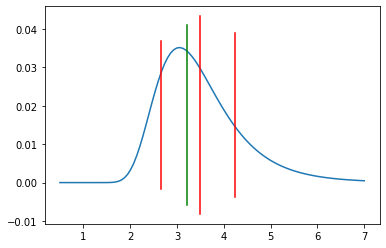

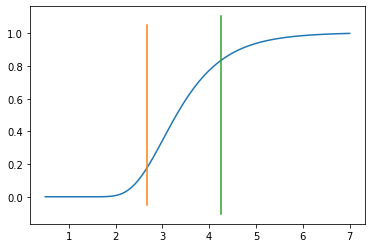

In [71]:
# get the marginal distribution function by marginalizing (summing) over the neab axis
mdf= Ppdf.sum(axis=1) 
plt.plot(sgrid,mdf)

# get the cumulative distribution function of this to determined credible region
cdf= np.cumsum(mdf)

# determine the 1-sigma credible region, i.e. where cdf>0.16 and cdf<0.84
cred=np.where((cdf>0.16)&(cdf<0.84))[0]
xmin=sgrid[cred[0]]
xmax=sgrid[cred[-1]]
print('credible interval: ',xmin,xmax)
plt.plot([xmin,xmin],plt.ylim(),color='r')
plt.plot([xmax,xmax],plt.ylim(),color='r')


# overplot the sample standard deviation
plt.plot([sample_std,sample_std],plt.ylim(),color='g')

# plot the mean of the marginal distribution function
mean=(sgrid*mdf).sum()
plt.plot([mean,mean],plt.ylim(),color='r')


plt.figure()
plt.plot(sgrid,cdf)
plt.plot([xmin,xmin],plt.ylim())
plt.plot([xmax,xmax],plt.ylim())
